In [ ]:
# ==============================================================
# CONFIGURAÇÃO: caminho da pasta com as imagens
# ==============================================================
root = "/content/Data"   # ajuste se a pasta estiver em outro lugar

In [ ]:
# --------------------------------------------------------------
# 1. Leitura de metadados: caminhos e rótulos
# --------------------------------------------------------------
import os, glob, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

# Procuramos recursivamente arquivos .jpg/.jpeg/.png
paths = [p for p in glob.glob(f"{root}/**/*.*", recursive=True)
         if p.lower().endswith((".jpg", ".jpeg", ".png"))]

# Monta DataFrame com caminho e rótulo (nome da pasta imediatamente acima)
df = pd.DataFrame({
    "path": paths,
    "classe": [os.path.basename(os.path.dirname(p)) for p in paths]
})

print("Total de imagens :", len(df))
print("\nDistribuição por classe:\n", df.classe.value_counts())

Total de imagens : 2489

Distribuição por classe:
 classe
Infrastructure    1418
Water_Disaster    1035
Earthquake          36
Name: count, dtype: int64


<ipython-input-5-62780e5f541c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="classe",


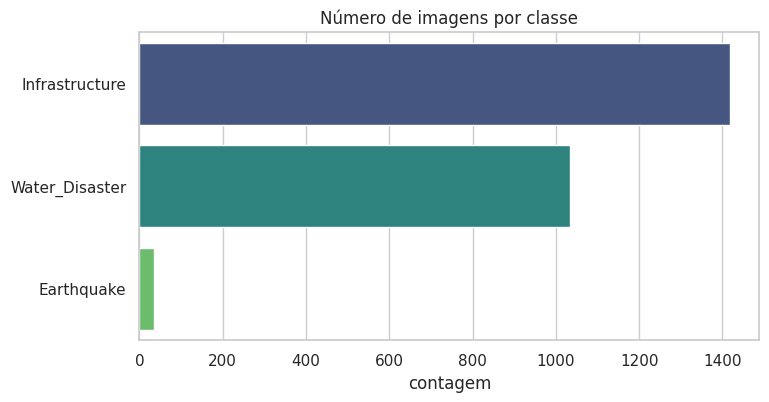

In [ ]:
# --------------------------------------------------------------
# 2. Gráfico de barras da distribuição de classes
# --------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.countplot(data=df, y="classe",
              order=df.classe.value_counts().index,
              palette="viridis")
plt.title("Número de imagens por classe")
plt.xlabel("contagem"); plt.ylabel("")
plt.show()

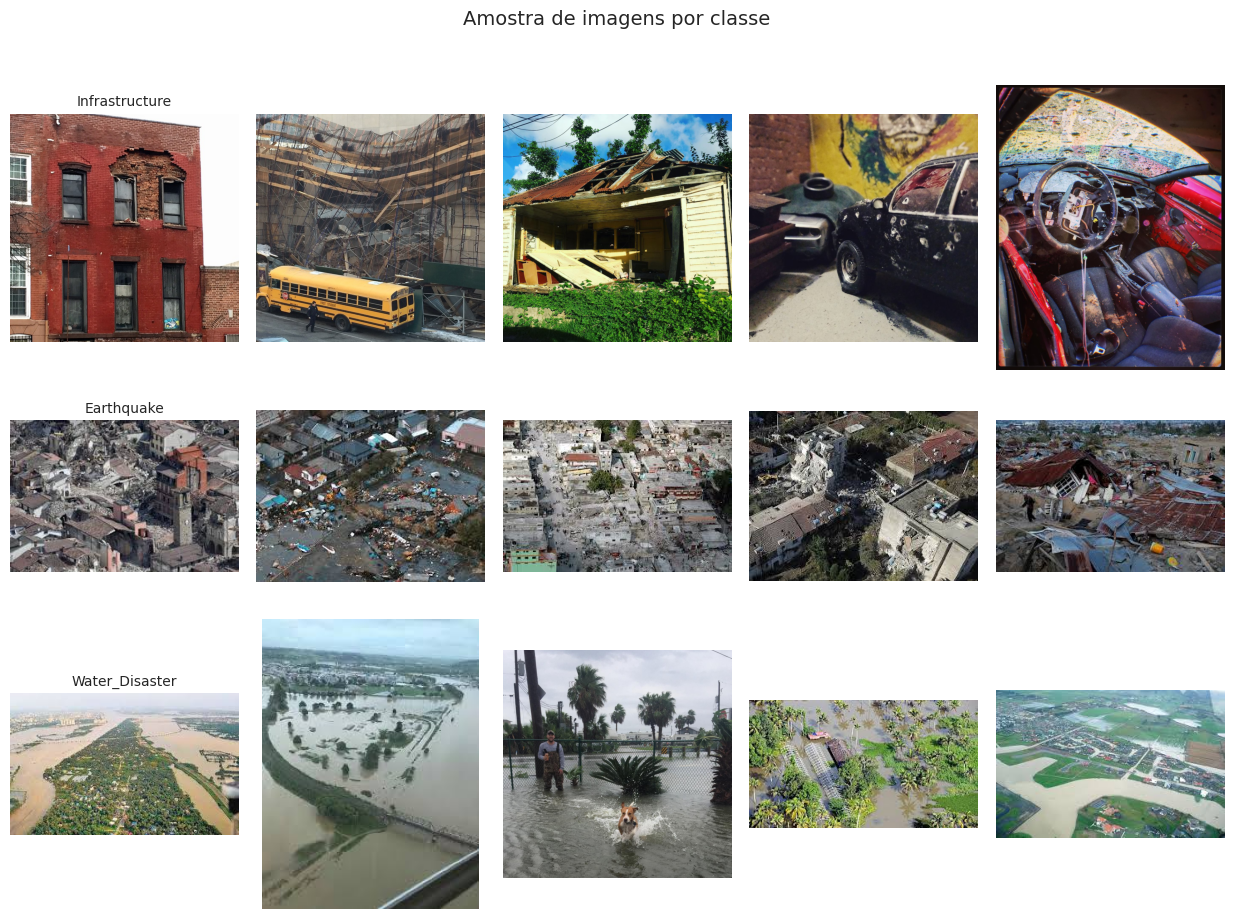

In [ ]:
# --------------------------------------------------------------
# 3. Amostra visual: n imagens por classe
# --------------------------------------------------------------
from PIL import Image

n = 5                                    # quantas imagens por classe
classes = df.classe.unique()             # rótulos existentes
fig, axs = plt.subplots(len(classes), n,
                        figsize=(2.5*n, 3*len(classes)))

for i, c in enumerate(classes):
    subset = df[df.classe == c].sample(
        n=min(n, len(df[df.classe == c])),
        random_state=42
    )
    for j, path in enumerate(subset.path):
        axs[i, j].imshow(Image.open(path))
        axs[i, j].axis("off")
        if j == 0:                       # título só na 1ª coluna
            axs[i, j].set_title(c, fontsize=10)
plt.suptitle("Amostra de imagens por classe", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

Dimensão média: 719.9 × 634.6


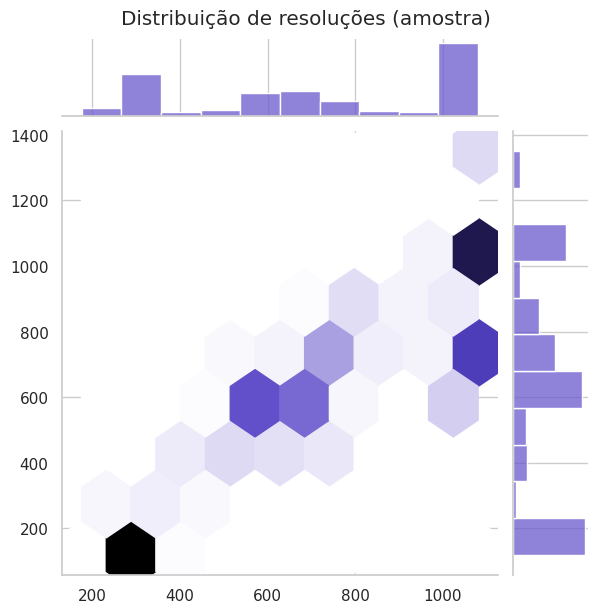

In [ ]:
# --------------------------------------------------------------
# 4. Estatísticas de resolução (largura × altura)
# --------------------------------------------------------------
# Para não sobrecarregar o notebook, pegamos amostra de 500 imagens
dims = [Image.open(p).size for p in df.path.sample(
            min(500, len(df)), random_state=0)]
w, h = zip(*dims)

print(f"Dimensão média: {sum(w)/len(w):.1f} × {sum(h)/len(h):.1f}")

# Mapa hexbin das resoluções
sns.jointplot(x=w, y=h, kind="hex", color="slateblue")
plt.suptitle("Distribuição de resoluções (amostra)", y=1.02)
plt.show()

## Conclusão

A análise exploratória revelou:

* **Desbalanceamento severo** – 57 % *Infrastructure*, 42 % *Water_Disaster* e apenas 1,4 % *Earthquake*.
* **Grande variância de resolução e proporção** – imagens de 200 px até 1 400 px, razões paisagem/retrato/quadrado.
* **Possível sobreposição semântica** entre *Infrastructure* e *Earthquake* (ambas retratam danos estruturais).

Esses achados motivaram as escolhas técnicas:

1. **Backbone compacto e congelado** – DINO ViT-Small/8, ~22 M parâmetros, adequado para CPU e dataset modesto.  
2. **Pré-processamento robusto** – resize 224 × 224, conversão RGB, filtragem de arquivos corrompidos.  
3. **Treino focado no classificador** – acelera convergência e reduz overfitting.

Recomendações para evolução:

* Aplicar **balanceamento de classes** (oversampling ou `class_weights`/focal-loss) para melhorar recall de *Earthquake*.  
* Adicionar **data-augmentation dirigida** (RandomResizedCrop, ColorJitter) para mitigar variação de resolução e aspecto.  
* Coletar mais imagens de terremotos ou usar técnicas de *data synthesis* para ampliar a classe minoritária.  
* Monitorar **métricas por classe** em vez de apenas acurácia global.

Em síntese, a solução entrega um pipeline funcional de classificação de desastres, alinhado às restrições de hardware e fundamentado por uma EDA criteriosa. Com as melhorias propostas, espera-se elevar a robustez e a equidade do modelo entre todas as categorias de desastre.